# Ensemble DTM of the world at 30m: Demonstration of how to access and use data as ARCO

This tutorial is going to access the data, see the overview, find and crop your area of interest and finally calculate hillshade. 

Thr ensemble DTM is derived from the **GLO-30** (DSM in 30m of whole world except for Azerbaijan), **AW3D30** 
(DSM in 30m of whole world), **MERIT** (DEM in about 90 mof whole world by removing multiple error components), and other global and national DTMs. According to the algrithm, the model is flexible and can be improved by adding more DTMs in. This model has two layer. One is the ensemble DTM in decimeter (dm), and the other represents the uncertainty among models. 

In [1]:
import rasterio
from pathlib import Path
import os
import warnings
warnings.filterwarnings("ignore")
from functions.access import get_ensem_dtm_bare_earth_url, get_ensem_dtm_std_url
from functions.access import read_overview

In [2]:
ensemble_dtm_url = get_ensem_dtm_bare_earth_url()
ensemble_dtm_std_url = get_ensem_dtm_std_url()

print(f' - Ensemble DTM bare earth COG: {ensemble_dtm_url}')
print(f' - Ensemble DTM standard deivation COG: {ensemble_dtm_std_url}')

 - Ensemble DTM bare earth COG: https://s3.eu-central-1.wasabisys.com/openlandmap/dtm/dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230130.tif
 - Ensemble DTM standard deivation COG: https://s3.eu-central-1.wasabisys.com/openlandmap/dtm/dtm.bareearth_ensemble_std_30m_s_2018_go_epsg4326_v20230130.tif


## Overview Access
It's possible to use the [rasterio](https://rasterio.readthedocs.io/en/latest/) library to access the metadata of these files without read all the data to the memory:

In [3]:
url = ensemble_dtm_url
src = rasterio.open(url)

print(f'File {url}\n')
for (key, val) in src.profile.items():
    print(f'-{key}: {val}')

File https://s3.eu-central-1.wasabisys.com/openlandmap/dtm/dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230130.tif

-driver: GTiff
-dtype: int16
-nodata: -32767.0
-width: 1296000
-height: 524999
-count: 1
-crs: EPSG:4326
-transform: | 0.00, 0.00,-180.00|
| 0.00,-0.00, 83.83|
| 0.00, 0.00, 1.00|
-blockxsize: 1024
-blockysize: 1024
-tiled: True
-compress: deflate
-interleave: band


Multiplying the width by the height it's possible to understand that it's a BIG image:

In [4]:
n_pixels = src.profile['width'] * src.profile['height']
print(f'Total number of pixels: {n_pixels}')

Total number of pixels: 680398704000


#### *!!! Please do not try to open the whole file with your memory. It would crash your work station !!!*

However you can use the COG structure to calculate the shape of a low resolution overview, reading a small portion of the data in a quickly thumbnail format:

In [5]:
overview, src = read_overview(ensemble_dtm_url, oviews_pos=6, verbose=True)
print(f'\nOverview dimensions: {overview.shape}')

Reading https://s3.eu-central-1.wasabisys.com/openlandmap/dtm/dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230130.tif
-Available overviews: [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2047]

Overview dimensions: (4101, 10125)


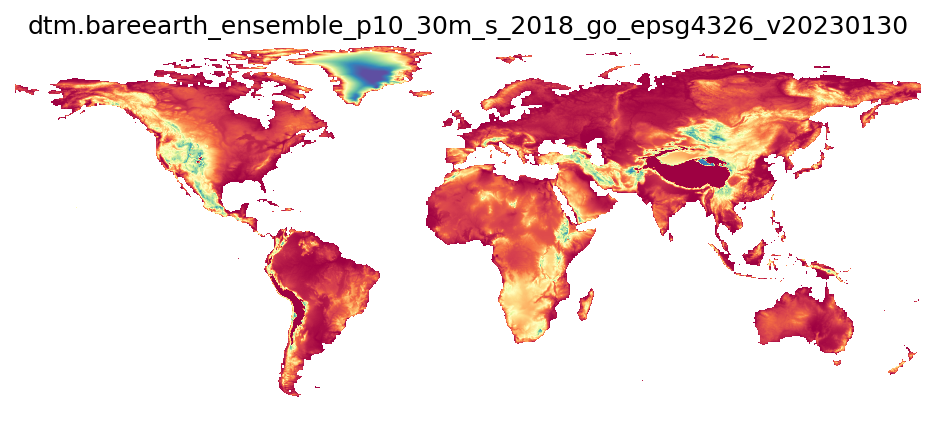

In [6]:
from eumap import plotter
plotter.plot_rasters(overview, figsize=8, cmaps='Spectral', nodata=src.nodata, vmin=0, vmax=30000, titles=[Path(ensemble_dtm_url).stem])

## Reading and Writing

 To access the dataset in a full resolution, it's recommended subset the COG file by a geographic region.To help in the definition of this region, let's make an interactive map with [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/), defining a `DrawControl` and add it to the map controls.

In [7]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

m = Map(center=(51.98, 5.65), zoom = 9, basemap= basemaps.OpenStreetMap.Mapnik)

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillOpacity": 0,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [8]:
from shapely.geometry import shape
from rasterio.windows import Window, from_bounds

geometry = shape(draw_control.data[-1]['geometry'])
bounds = geometry.bounds
window = fromv20230130_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.transform)
print("\nBounds: ", bounds[0], bounds[1], bounds[2], bounds[3])
print("Raster window:", window)


Bounds:  5.334163 51.97161 6.100459 52.105082
Raster window: Window(col_off=667202.9868020318, row_off=114218.70480034497, width=2758.6656000084477, height=480.4992000014754)


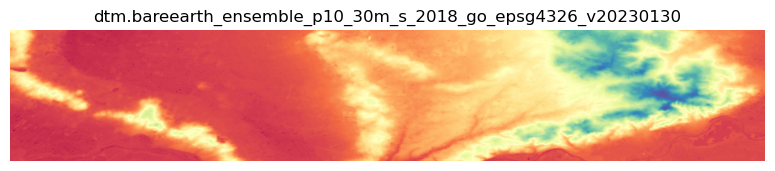

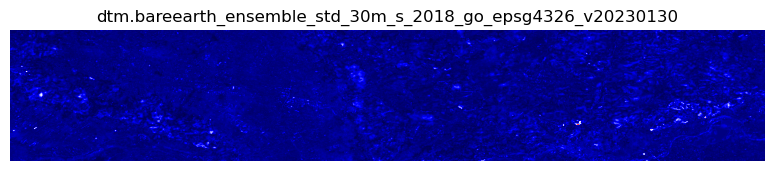

In [9]:
from eumap.raster import read_rasters, save_rasters

dtm_cog_url = get_ensem_dtm_bare_earth_url()
dtm_std_cog_url = get_ensem_dtm_std_url()


dtm, _ = read_rasters(raster_files=[dtm_cog_url], spatial_win=window, dtype='float32')
std, _ = read_rasters(raster_files=[dtm_std_cog_url], spatial_win=window, dtype='float32')
plotter.plot_rasters(dtm[:,:,0], cmaps='Spectral', dpi=100, nodata=src.nodata,titles=[Path(dtm_cog_url).stem])
plotter.plot_rasters(std[:,:,0], cmaps='seismic', dpi=100, nodata=src.nodata,titles=[Path(dtm_std_cog_url).stem])

In [10]:
raster_dir = Path(os.getcwd())

file_name = f'{Path(dtm_cog_url).stem}_clip.tif'
file_path = raster_dir.joinpath(file_name)

print(f"Saving file in {file_path}")
r = save_rasters(dtm_cog_url, [file_path], dtm, spatial_win=window, dtype='float32')

Saving file in /home/opengeohub/faen/work/global-layers/input_layers/Ensemble_dem/dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230130_clip.tif


In [11]:
from os import system, unlink
# create a hillshade
hillshade = "dtm.bareearth_ensemble_hillshade_2018_epsg4326_v20230130_clip.tif"
system('gdaldem hillshade ./dtm.bareearth_ensemble_p10_30m_s_2018_go_epsg4326_v20230130_clip.tif -z 0.1 ./tmp.tif -combined -compute_edges -co "COMPRESS=DEFLATE" -co \"BIGTIFF=YES\"')
system('gdal_translate ./tmp.tif ' './'+ hillshade + ' -mo \"CO=YES\" -co \"TILED=YES\" -co \"BIGTIFF=YES\" -co NUM_THREADS=' + str(80) + ' -co \"BLOCKYSIZE=512\" -co \"COMPRESS=LZW\" -co \"COPY_SRC_OVERVIEWS=YES\" --config GDAL_TIFF_OVR_BLOCKSIZE 512')
unlink('./tmp.tif')

Warning 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed
ERROR 1: PROJ: proj_create_from_name: Open of /opt/conda/share/proj failed
Warning 1: General options of gdal_translate make the COPY_SRC_OVERVIEWS creation option ineffective as they hide the overviews
ERROR 1: PROJ: proj_create_from_name: Open of /opt/conda/share/proj failed


0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 2758, 480
0...10...20...30...40...50...60...70...80...90...100 - done.


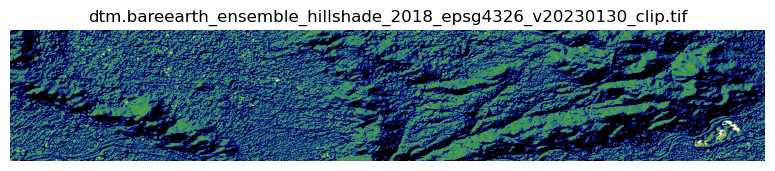

In [12]:
hill_data = rasterio.open(hillshade).read(1)
plotter.plot_rasters(hill_data, cmaps='gist_earth', dpi=100, nodata=src.nodata,titles=[hillshade])